# Análisis Exploratorio - Generación Solar Planta 239/309/346

Visualización de patrones clave en datos de generación solar y meteorológicos.

In [21]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path.cwd().parent
sys.path.insert(0, str(BASE_DIR))
from src.config import get_plant_config

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

In [22]:
# Cargar datos procesados
ID_PLANTA = 305  # Cambiar según planta: 239, 309, 346

plant_config = get_plant_config(ID_PLANTA)
FECHA_INICIO = plant_config['fecha_inicio']
FECHA_FIN = plant_config['fecha_fin']

PROCESSED_PATH = BASE_DIR / 'data' / '03_processed' / f'DatosCombinados_{FECHA_INICIO}_a_{FECHA_FIN}_Planta{ID_PLANTA}.csv'
df = pd.read_csv(PROCESSED_PATH, index_col=0, parse_dates=True)

print(f"✅ Planta {ID_PLANTA} | {plant_config['nombre']} ({plant_config['potencia_mw']} MW)")
print(f"📊 Datos: {len(df):,} horas | {df.index.min()} a {df.index.max()}")

✅ Planta 305 | Las Terrazas (2.99 MW)
📊 Datos: 8,761 horas | 2014-10-30 00:00:00 a 2015-10-30 00:00:00


## 1. Serie Temporal - Generación Solar con Feriados

📅 Feriados/Mantenimiento detectados: 43 días (1032 horas totales)


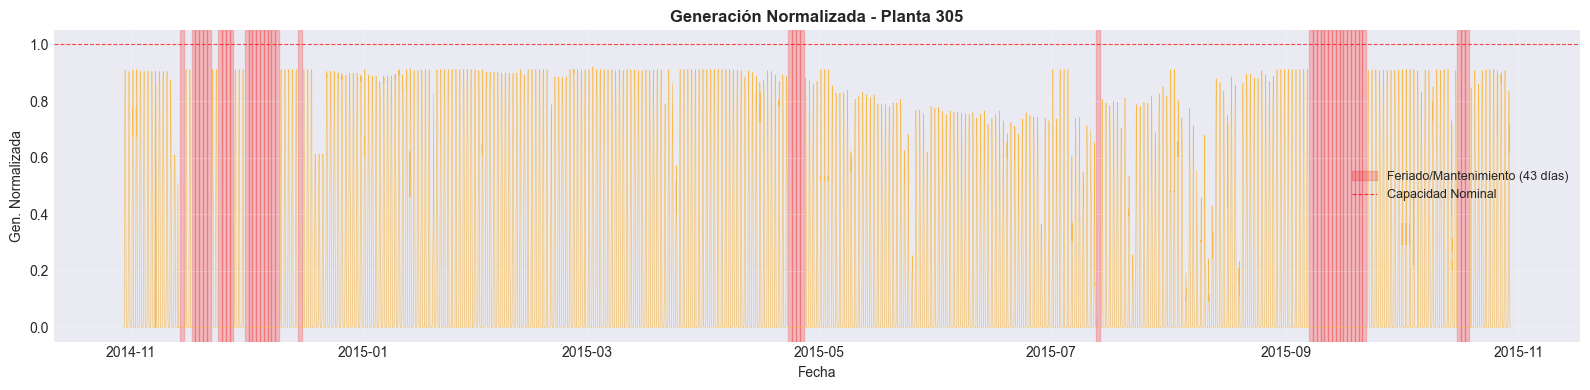

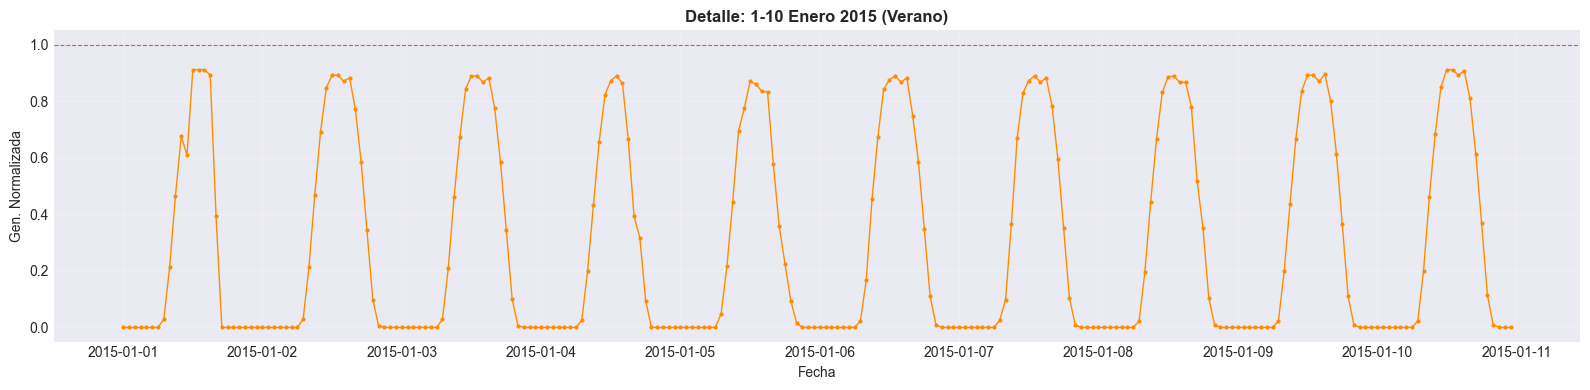

In [28]:
# Serie temporal completa
fig1, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df.index, df['gen_normalizada'], linewidth=0.4, alpha=0.7, color='orange')

# Marcar feriados/mantenimiento
if 'feriado' in df.columns:
    feriados = df[df['feriado'] == 1]
    if len(feriados) > 0:
        dias_feriado_unicos = sorted(set(feriados.index.date))
        print(f"📅 Feriados/Mantenimiento detectados: {len(dias_feriado_unicos)} días ({len(feriados)} horas totales)")
        for idx, dia in enumerate(dias_feriado_unicos):
            inicio_dia = pd.Timestamp(year=dia.year, month=dia.month, day=dia.day)
            fin_dia = inicio_dia + pd.Timedelta(days=1)
            if idx == 0:
                ax1.axvspan(inicio_dia, fin_dia, alpha=0.2, color='red', zorder=0, 
                            label=f'Feriado/Mantenimiento ({len(dias_feriado_unicos)} días)')
            else:
                ax1.axvspan(inicio_dia, fin_dia, alpha=0.2, color='red', zorder=0)
    else:
        print("✅ No se detectaron feriados/mantenimientos en el período")
else:
    print("⚠️ Columna 'feriado' no disponible en los datos")

ax1.set_title(f'Generación Normalizada - Planta {ID_PLANTA}', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Gen. Normalizada')
ax1.grid(True, alpha=0.2)
ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=0.8, alpha=0.7, label='Capacidad Nominal')
ax1.legend(fontsize=9)
plt.tight_layout()
plt.show()

# Zoom: 10 días de verano
df_zoom = df['2015-01-01':'2015-01-10']
fig2, ax2 = plt.subplots(figsize=(16, 4))
ax2.plot(df_zoom.index, df_zoom['gen_normalizada'], linewidth=1, color='darkorange', marker='o', markersize=2)

if 'feriado' in df_zoom.columns:
    feriados_zoom = df_zoom[df_zoom['feriado'] == 1]
    if len(feriados_zoom) > 0:
        for dia in sorted(set(feriados_zoom.index.date)):
            inicio_dia = pd.Timestamp(year=dia.year, month=dia.month, day=dia.day)
            fin_dia = inicio_dia + pd.Timedelta(days=1)
            ax2.axvspan(inicio_dia, fin_dia, alpha=0.3, color='red', zorder=0)

ax2.set_title('Detalle: 1-10 Enero 2015 (Verano)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Gen. Normalizada')
ax2.grid(True, alpha=0.2)
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
plt.tight_layout()
plt.show()


## 2. Heatmap - Generación por Hora y Mes

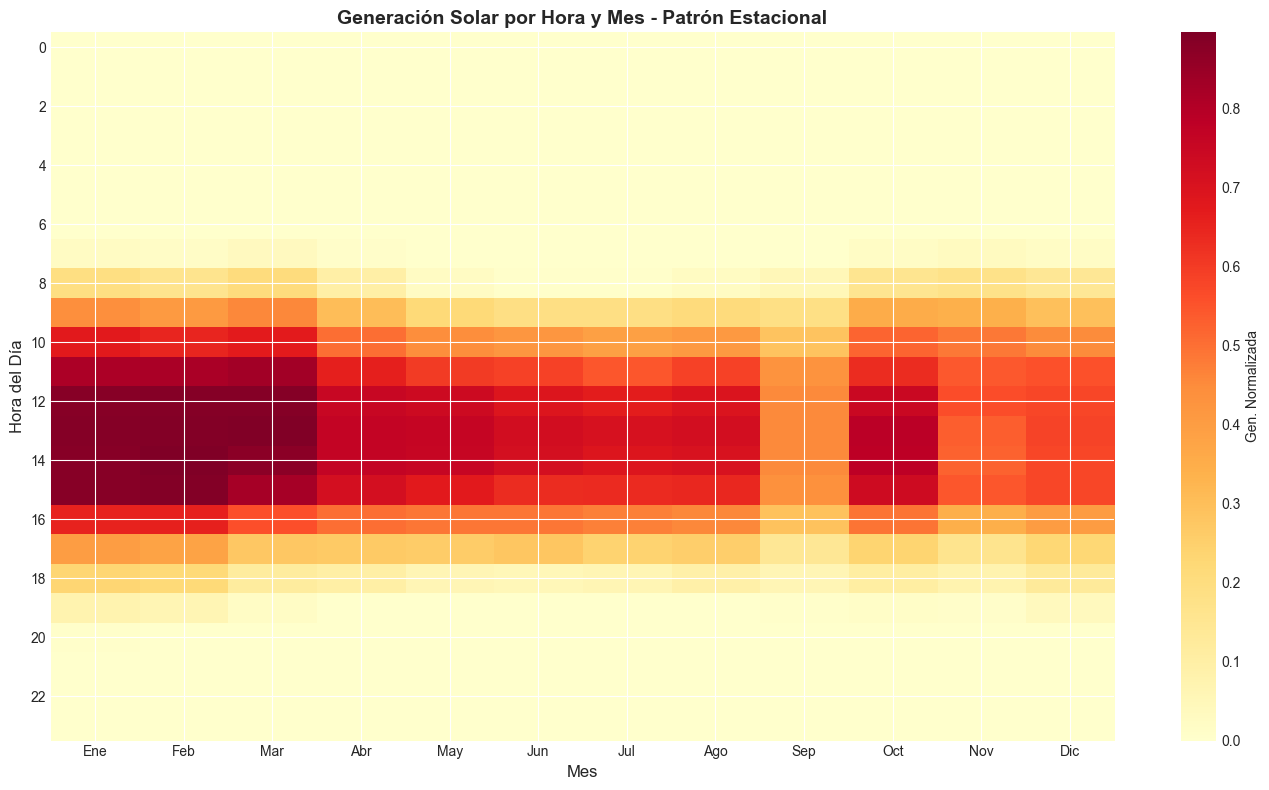

In [24]:
# Heatmap: Generación por Hora y Mes (patrón estacional)
df['hour'] = df.index.hour
df['month'] = df.index.month

pivot_hour_month = df.pivot_table(values='gen_normalizada', index='hour', columns='month', aggfunc='mean')

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(pivot_hour_month.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_title('Generación Solar por Hora y Mes - Patrón Estacional', fontsize=14, fontweight='bold')
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Hora del Día', fontsize=12)
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax.set_yticks(range(0, 24, 2))
plt.colorbar(im, ax=ax, label='Gen. Normalizada')
plt.tight_layout()
plt.show()

## 3. Matriz de Correlación - Variables Meteorológicas

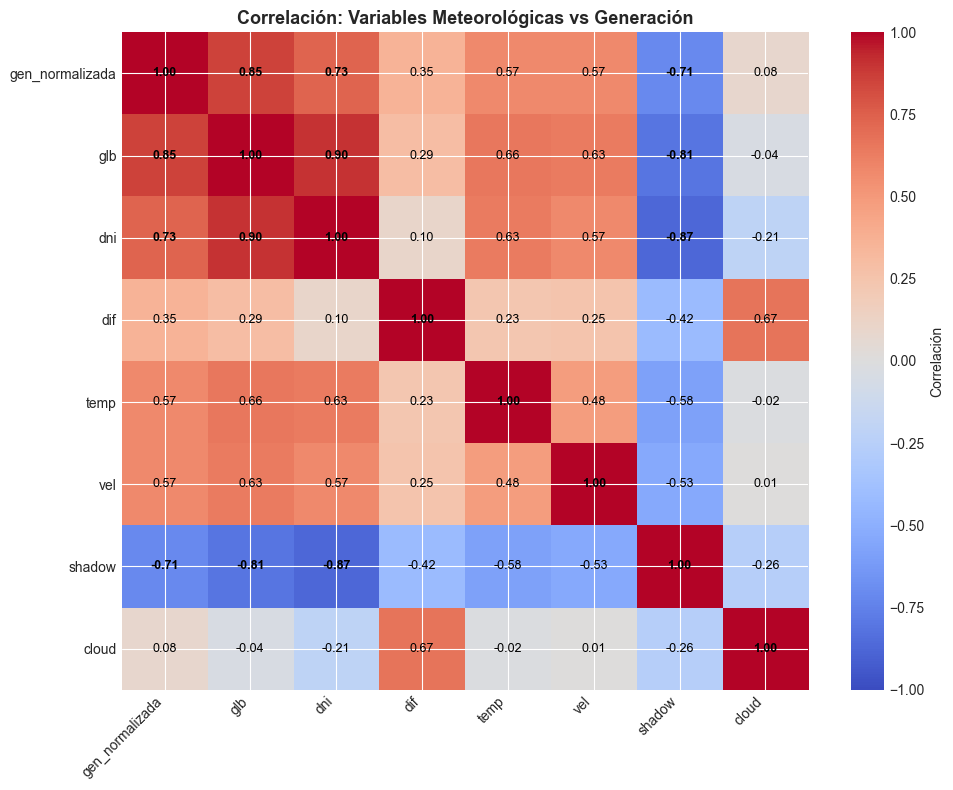

In [25]:
# Correlaciones entre variables meteorológicas y generación
vars_corr = ['gen_normalizada', 'glb', 'dni', 'dif', 'temp', 'vel', 'shadow', 'cloud']
corr_matrix = df[vars_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(range(len(vars_corr)))
ax.set_yticks(range(len(vars_corr)))
ax.set_xticklabels(vars_corr, rotation=45, ha='right')
ax.set_yticklabels(vars_corr)

# Valores de correlación
for i in range(len(vars_corr)):
    for j in range(len(vars_corr)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9,
                       fontweight='bold' if abs(corr_matrix.iloc[i, j]) > 0.7 else 'normal')

ax.set_title('Correlación: Variables Meteorológicas vs Generación', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Correlación')
plt.tight_layout()
plt.show()

## 4. Autocorrelación (ACF/PACF) - Justificación Ventana LSTM 24h

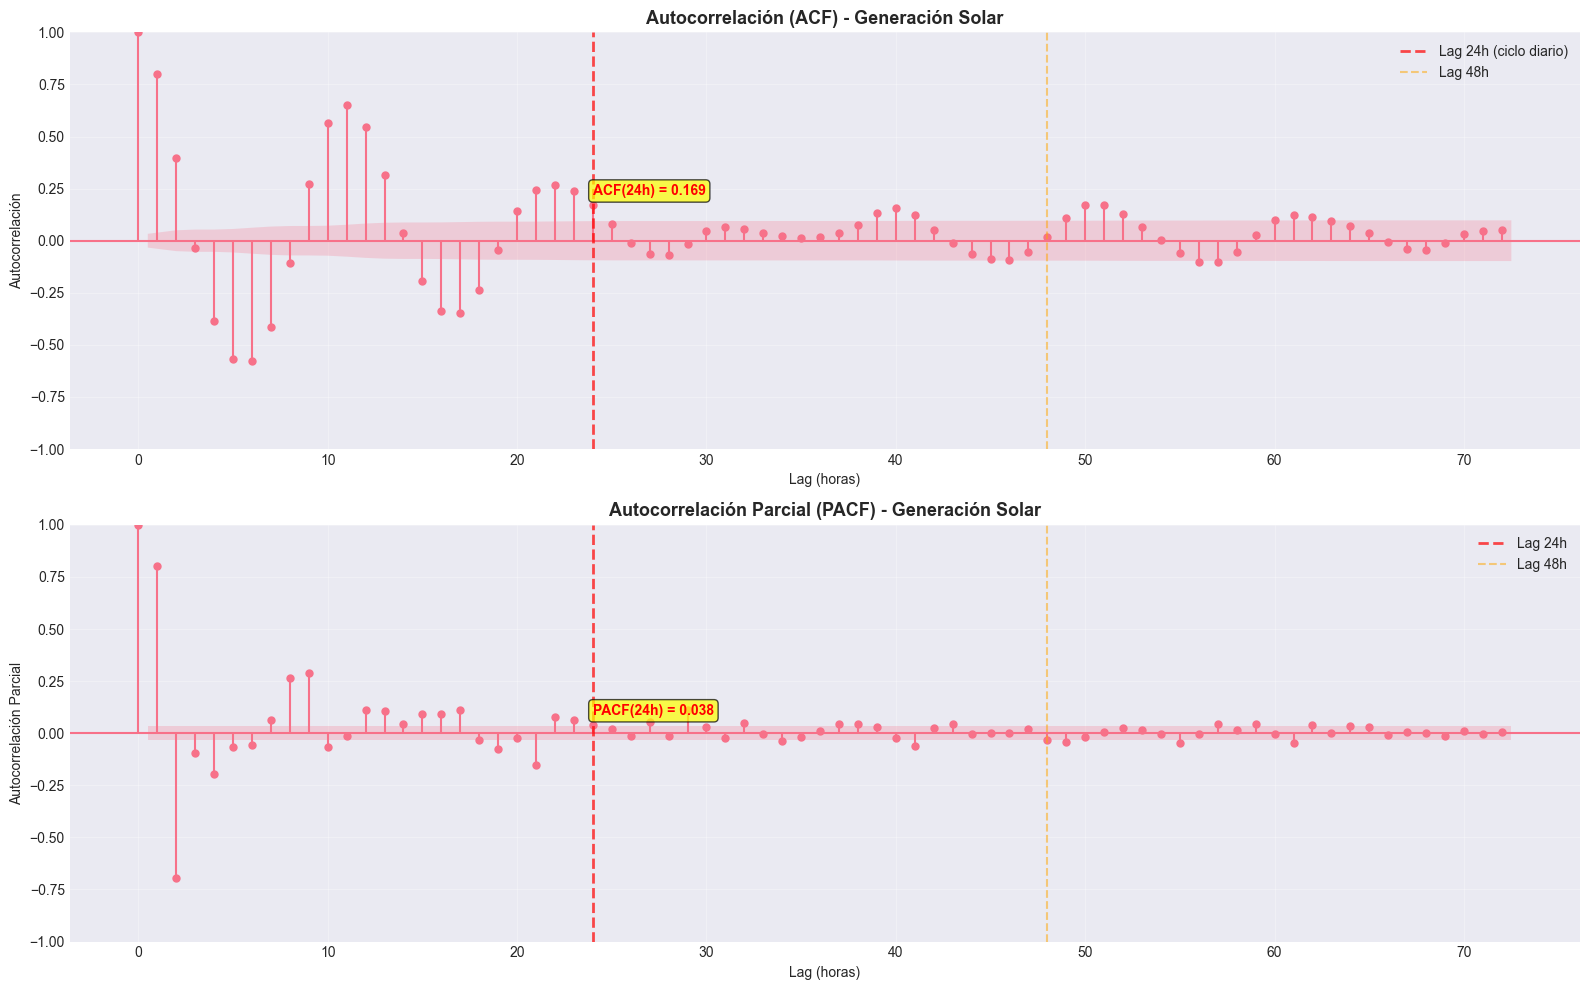

✅ ACF(24h) = 0.169 | PACF(24h) = 0.038
→ Alta correlación temporal en lag=24h justifica ventana BiLSTM de 24 horas


In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Filtrar datos diurnos
df_day = df[df['gen_normalizada'] > 0.01]['gen_normalizada'].copy()

n_lags = 72
acf_values = acf(df_day.dropna(), nlags=n_lags, fft=True)
pacf_values = pacf(df_day.dropna(), nlags=n_lags, method='ywm')

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF
ax1 = axes[0]
plot_acf(df_day.dropna(), lags=n_lags, ax=ax1, alpha=0.05)
ax1.set_title('Autocorrelación (ACF) - Generación Solar', fontsize=13, fontweight='bold')
ax1.set_xlabel('Lag (horas)')
ax1.set_ylabel('Autocorrelación')
ax1.axvline(x=24, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Lag 24h (ciclo diario)')
ax1.axvline(x=48, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Lag 48h')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.text(24, acf_values[24] + 0.05, f'ACF(24h) = {acf_values[24]:.3f}', 
         fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# PACF
ax2 = axes[1]
plot_pacf(df_day.dropna(), lags=n_lags, ax=ax2, alpha=0.05, method='ywm')
ax2.set_title('Autocorrelación Parcial (PACF) - Generación Solar', fontsize=13, fontweight='bold')
ax2.set_xlabel('Lag (horas)')
ax2.set_ylabel('Autocorrelación Parcial')
ax2.axvline(x=24, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Lag 24h')
ax2.axvline(x=48, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Lag 48h')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.text(24, pacf_values[24] + 0.05, f'PACF(24h) = {pacf_values[24]:.3f}', 
         fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"✅ ACF(24h) = {acf_values[24]:.3f} | PACF(24h) = {pacf_values[24]:.3f}")
print(f"→ Alta correlación temporal en lag=24h justifica ventana BiLSTM de 24 horas")

## 5. Distribución y Outliers - Variables Clave

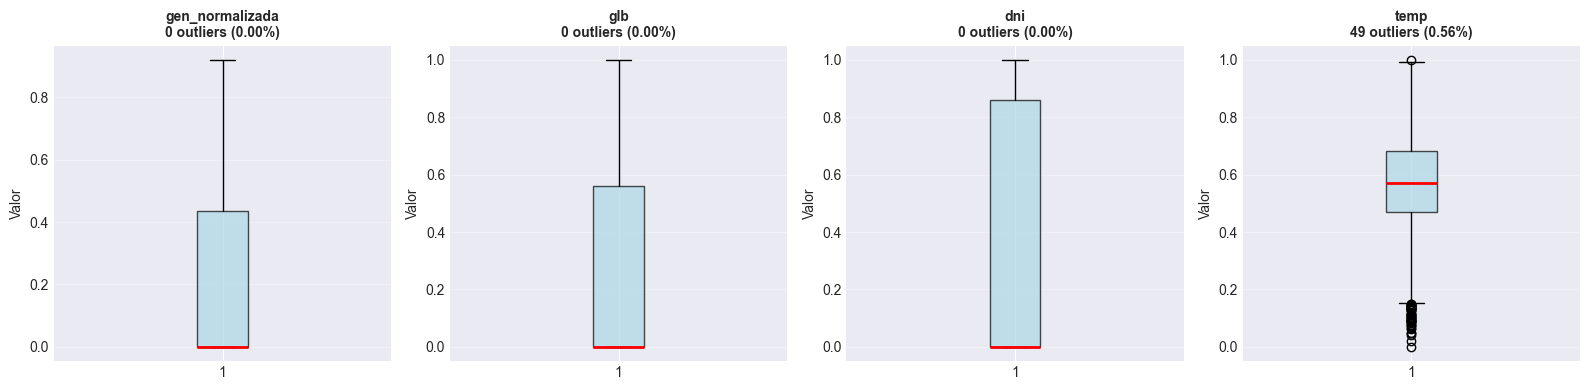

In [27]:
# Detección de outliers (IQR)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] < lower) | (data[column] > upper)]

# Boxplots de variables clave
vars_box = ['gen_normalizada', 'glb', 'dni', 'temp']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, var in enumerate(vars_box):
    ax = axes[idx]
    bp = ax.boxplot(df[var].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    
    outliers = detect_outliers_iqr(df, var)
    n_outliers = len(outliers)
    pct = (n_outliers / len(df)) * 100
    
    ax.set_title(f'{var}\n{n_outliers} outliers ({pct:.2f}%)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Valor')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()